# Deep learning

In the previous lecture, we learned about conventional machine learning approaches for regression and classification. We found that such models have useful analytical and computational properties but that their practical applicability to common tasks in Earth Science was limited. These tasks require models that can automatically recognize complex patterns in our data. For our image classification, this might be the shape or texture of meltwater ponds on the ice sheet. For our time-series prediction, this might be changing sensitivity of discharge to air temperature during different times of the year (e.g. caused by snowpack dynamics). 

More powerful approaches for statistical pattern recognition are provided by a class of models called **neural networks**. The term "neural network" has its origins in attempts to find mathematical representations of information processing in biological systems. Neural networks have multiple hidden layers which allows them learn increasingly abstract representations in our data. We therefore refer to this type of machine learning as **deep learning**. 

The quintessential model of this type is known as a **feed-forward neural network** (or multilayer perceptron). These models are called **feed-forward** because information flows from the input layer, through hidden layers, to the output layer without looping back. When feed-forward neural networks are extended to include **feedback connections**, they can recognize sequences in data (e.g. temporal dependencies). These type of models are called **recurrent neural networks** (RNNs). Likewise, when **convolutional layers** are added to feed-forward neural networks, they can start to learn spatial dependencies in our data (e.g. shape and texture of image). We call these models **convolutional neural networks** (CNNs). 

In this lecture, we will develop an understanding of neural networks and demonstrate how they can be applied to improve performance on our image classification and time-series prediction tasks.

## Example - Nisqually River discharge

As always, we will use an example to demonstrate key concepts.

```{image} images/nisqually.png
:width: 600px
:align: center
```

Just like before, we will read our training dataset which contains climate data as features and discharge as the target variable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler

# Read data
df = pd.read_csv('data/nisqually.csv', parse_dates=['Date'], index_col=['Date'])

# Define feature list
feature_list =  df.columns.to_list()[:-1]
X = df[feature_list]
y = df['Nisqually Discharge']

Nex we will standarize our features and define the task which is to train our model on 8 years of discharge between 2013 and 2020 so that it can predict a whole year of discharge for 2021 from just climate data. Note that it is safer to also scale our target variable when training a deep learning model. 

In [2]:
# Standarize features
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.index = X.index

# Define start and end
start = '2021-01-01'
end = '2021-12-31'

# Split data 
X_train = X_scaled[:start]
X_test = X_scaled[start:end]
y_train = y[:start]
y_test = y[start:end]

# Scale target
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1,1))

## `TensorFlow`

Now we will define a relatively simple **multilayer perceptron** (or feed-forward neural network). To do this, we will use `TensorFlow`, an open-source deep learning package developed by Google. `TensorFlow` provides the tools for building and training neural networks and is widely used in academia and industry. The name is derived from two core ideas: a **tensor** which is basically array of numbers (which may be higher dimensional than a vector or a matrix, which are 1D and 2D tensors) and **flow** which describes the movement of the tensors through some sort of computational network (e.g multiply, convolution, activation). 

In [3]:
from tensorflow.keras import layers, models

# Define shape of training data
input_dim = X_train.shape[1]

# Define neural network architecture
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'), 
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Show model summary
model.summary()

ModuleNotFoundError: No module named 'tensorflow'

This model has three main components:

* An input layer which takes a vector of size `input_dim`, representing the number of features in our climate data.

* Three hidden layers, each of which has 32 **neurons** which represent numbers (or **activations**) that correspond to patterns in the data. Initially, the numbers that the neurons represent are random but during training they are updated using a **ReLU (Rectified Linear Unit)** activation function.

* An output layer that produces a continuous value representing scaled discharge.

```{image} images/neuron.png
:width: 500px
:align: center
```

Our neural network is **fully connected** meaning that each 

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=0
)

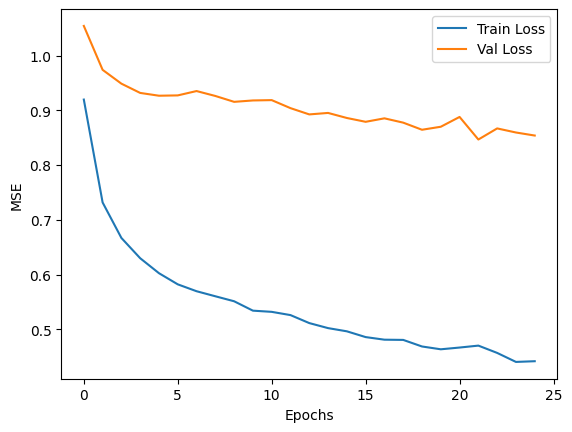

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


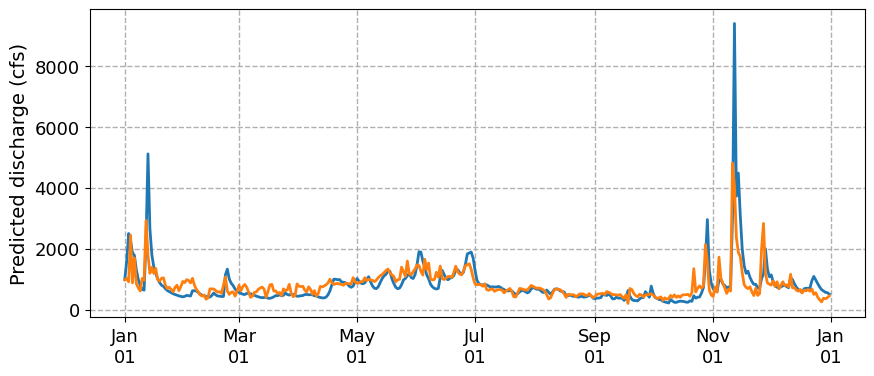

In [15]:
# Predict on test set
y_pred_scaled = model.predict(X_test).flatten()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(1, -1))

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['2021-01-01':'2021-12-31'].index, df['Nisqually Discharge']['2021-01-01':'2021-12-31'], lw=2, zorder=3)
ax.plot(y_test.index, y_pred[0,:], lw=2, zorder=3)
ax.set_ylabel('Predicted discharge (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%d'))

In [12]:
# Compute Nash-Sutcliffe index
nse = 1 - np.sum((y_test - y_pred[0,:]) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
print(f"NSE: {nse:.2f}")

NSE: 0.65
